In [1]:
import pandas as pd
import numpy as np
import warnings
from numba import jit 
import datetime
from time import time
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from sklearn import preprocessing
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import lightgbm as lgb
from functools import partial
import json
import copy
import time
import seaborn as sns
import scipy as sp
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows",1000)
np.set_printoptions(precision=8)
warnings.filterwarnings("ignore")

In [2]:
def qwk(a1, a2):
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return np.round(1 - o / e, 8)

In [3]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])
        return -qwk(y, X_p)
    
    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        
    def predict(self, X, coef):
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

    def coefficients(self):
        return self.coef_['x']

# install

In [4]:
first_rows = [2618, 6023, 6068, 7264, 8524, 11480, 19558, 20762, 23384, 23430, 24381, 25357, 25557, 
              32220, 37632, 45419, 46144, 49211, 55393, 58271, 58636, 60064, 65371, 67355,71391, 
              72906, 75477, 78084, 80155, 80335, 81946, 82258, 83780, 84852, 85158, 87908,
              90229, 95763, 99365, 100092, 100672, 108475, 111782, 113260, 114560, 116088, 123267,
              123471, 125304, 125964, 127510, 128930, 136090, 140549, 143043, 143710, 145901, 146752,
              159347, 164415, 171187, 172296, 172942, 173515, 182105, 186882, 191801, 199866, 201994,
              202917, 204407, 209028, 212648, 213584, 214201, 217041, 219526, 223597, 248902, 249618,
              253655, 257880, 258170, 260237, 261826, 262396, 264780, 274764, 276662, 282118, 284739,
              286442, 286836, 288434, 290643, 293958, 294745, 295810, 297085, 306499, 319517, 319718,
              320623, 324543, 325572, 326399, 329024, 335826, 336255, 340919, 341218, 348333, 350317,
              351715, 352858, 355889, 356522, 356925, 358177, 359890, 364985, 366433, 366655, 374337,
              376548, 376996, 377172, 379155, 380565, 380764, 383184, 386373, 387595, 399159, 401511,
              403372, 403836, 404879, 405444, 405999, 407649, 408160, 408549, 412141, 418080, 418600,
              420743, 421960, 439610, 453045, 454086, 454809, 457365, 457926, 463536, 469319, 471541,
              471850, 473058, 475806, 478811, 479857, 485821, 486402, 487215, 488439, 490114, 490672, 
              494350, 500843, 501803, 502628, 504264, 507229, 508453, 509402, 510120, 511694, 512612, 
              514502, 516129, 529965, 532674, 533995, 539122, 540142, 540672, 542892, 546531, 547241,
              548531, 548740, 551212, 552575, 553505, 554063, 554704, 555001, 560084, 560815, 564907,
              567390, 571758, 573851, 576248, 576691, 578919, 581097, 582542, 584670, 593732, 596746,
              598169, 599150, 606685, 608836, 609353, 610213, 611373, 619708, 621553, 623006, 625744,
              627348, 635665, 637337, 638737, 639696, 641494, 643790, 647604, 648502, 652046, 655612, 
              659736, 668244, 672878, 676315, 678283, 680602, 682693, 684132, 685375, 693697, 693988, 
              695012, 695506, 698732, 705417, 707752, 709859, 714646, 716312, 717685, 718872, 722107, 
              724762, 726579, 727289, 728416, 728808, 736146, 741097, 742870, 743078, 748363, 748980,
              751694, 752318, 754361, 756724, 758282, 759271, 760331, 762198, 762659, 766171, 766589,
              767404, 768053, 768388, 768946, 774831, 775130, 776021, 776198, 776331, 779542, 785819,
              787228, 789242, 792769, 794026, 796121, 798765, 799428, 799977, 801314, 804798, 810324,
              810536, 811865, 812607, 814806, 818288, 822744, 824175, 825903, 828089, 829224, 832316,
              835416, 836189, 838537, 841762, 849146, 850063, 851494, 854962, 855653, 855871, 859223, 
              860487, 861583, 865293, 881551, 882397, 882989, 893965, 899838, 907067, 920036, 921028,
              932374, 933119, 943775, 950328, 953423, 953618, 954424, 955025, 955483, 956588, 957628,
              961557, 962500, 967070, 967942, 968432, 973288, 974303, 974649, 976065, 979054, 979665, 
              983077, 983505, 988543, 989839, 995238, 999570, 1000941, 1002117, 1002378, 1003974,1005495,
              1006450, 1009345, 1011946, 1013758, 1020656, 1043609, 1047168, 1052319, 1053901, 1064822,
              1066022, 1070751, 1077000, 1078021, 1079329, 1080649, 1082682, 1083524, 1084174, 1084428,
              1085440, 1085747, 1086026, 1090580, 1096816, 1103062, 1103873, 1105341, 1109305, 1110435, 
              1110648, 1113853, 1115940, 1123834, 1126289, 1126383, 1131226, 1131763, 1132652, 1132797, 
              1134453, 1135766, 1136477, 1137296, 1140433, 1143527, 1144375, 1145428, 1146717, 1159858,
              1165743, 1172980, 1178857, 1180004, 1181651, 1183880, 1185173, 1187067, 1187382, 1193864,
              1198474, 1198716, 1202991, 1204862, 1206233, 1216032, 1219669, 1219960, 1225550, 1227807,
              1228406, 1229222, 1229643, 1232099, 1233595, 1238494, 1240508, 1240886, 1243943, 1244425,
              1246674, 1256130, 1260881, 1264484, 1266006, 1267070, 1268359, 1269563, 1271465, 1272207,
              1278058, 1281694, 1281937, 1283916, 1284477, 1286566, 1287227, 1289070, 1289243, 1295943,
              1298044, 1298370, 1300768, 1306837, 1312381, 1312618, 1314317, 1320449, 1326578, 1330101, 
              1331807, 1332761, 1332989, 1333990, 1336408, 1337796, 1338456, 1340963, 1344654, 1345131,
              1356828, 1359271, 1359341, 1363420, 1365792, 1366273, 1369297, 1381400, 1383686, 1387568, 
              1389134, 1389794, 1390384, 1393029, 1393937, 1402683, 1404630, 1405961, 1406378, 1407240, 
              1411499, 1411902, 1414225, 1424178, 1424911, 1429671, 1430806, 1434771, 1437691, 1466708,
              1468911, 1469586, 1470344, 1472050, 1482050, 1482528, 1483308, 1485302, 1497412, 1500566,
              1503303, 1504088, 1504919, 1505677, 1508877, 1520431, 1523516, 1524068, 1524396, 1525769,
              1527961, 1530319, 1532267, 1534177, 1535590, 1536719, 1539104, 1541010, 1542025, 1544951,
              1545318, 1545802, 1546557, 1566406, 1567045, 1569853, 1575313, 1580514, 1581254, 1585061,
              1586786, 1587693, 1593126, 1594870, 1607705, 1615005, 1617283, 1617643, 1618282, 1628175,
              1630439, 1631895, 1632498, 1634311, 1635309, 1642027, 1643713, 1645910, 1650723, 1653985,
              1654424, 1671720, 1674309, 1675225, 1676343, 1679405, 1680204, 1682390, 1682615, 1683919, 
              1686559, 1686745, 1690416, 1692279, 1692780, 1693434, 1694241, 1695960, 1698101, 1699123, 
              1701866, 1706741, 1708723, 1710654, 1711739, 1712350, 1714590, 1716397, 1721780, 1722589, 
              1724234, 1738697, 1742453, 1743656, 1745070, 1745873, 1745962, 1746225, 1750116, 1750292, 
              1750602, 1762989, 1781472, 1785964, 1786703, 1787295, 1790537, 1794378, 1796497, 1796980, 
              1799182, 1801579, 1814742, 1816475, 1817454, 1820567, 1823382, 1824914, 1825532, 1826505,
              1827229, 1828406, 1833041, 1837484, 1838860, 1840859, 1844161, 1849063, 1850195, 1852212, 
              1852599, 1853060, 1859431, 1859863, 1860668, 1861946, 1862776, 1870460, 1871074, 1871744,
              1872355, 1884099, 1897475, 1900537, 1902090, 1904855, 1906124, 1909932, 1910804, 1910994, 
              1912623, 1912858, 1915966, 1918399, 1926414, 1931663, 1933029, 1933614, 1935874, 1940629,
              1941183, 1947921, 1954172, 1954770, 1963402, 1963860, 1967044, 1967924, 1972234, 1975130,
              1981174, 1994801, 1995397, 1997088, 1999180, 1999876, 2001281, 2002428, 2003755, 2004732, 
              2007880, 2010350, 2011843, 2013099, 2014138, 2016351, 2016426, 2018918, 2021950, 2028058,
              2030863, 2035941, 2038989, 2041519, 2041981, 2044059, 2046137, 2046849, 2049564, 2050138,
              2054505, 2057932, 2058812, 2059464, 2061550, 2061762, 2068212, 2070491, 2071031, 2071318,
              2075410, 2077812, 2080173, 2086183, 2090387, 2092376, 2093262, 2096261, 2097130, 2102593,
              2103033, 2104715, 2111370, 2122217, 2129285, 2131908, 2134370, 2140486, 2142659, 2144285, 
              2144949, 2148070, 2148864, 2149318, 2151784, 2173274, 2176330, 2180042, 2187264, 2188487, 
              2194359, 2200721, 2201946, 2205691, 2209168, 2213029, 2214384, 2215777, 2217719, 2219053,
              2221628, 2225280, 2226950, 2231152, 2232506, 2233359, 2236989, 2242097, 2243594, 2243745,
              2243838, 2245161, 2248613, 2249165, 2252974, 2256628, 2258114, 2258647, 2259238, 2261970,
              2262903, 2263917, 2265229, 2265548, 2266408, 2270937, 2271328, 2277747, 2281778, 2283224, 
              2285738, 2289839, 2291341, 2295772, 2297194, 2300115, 2301058, 2303858, 2306461, 2307095, 
              2307513, 2307823, 2312014, 2313364, 2314536, 2315716, 2316512, 2317832, 2318486, 2325992, 
              2333003, 2335612, 2336643, 2339937, 2340357, 2346518, 2348864, 2352137, 2352700, 2353141, 
              2353754, 2354631, 2355356, 2356050, 2357274, 2358671, 2359415, 2363932, 2369256, 2369540,
              2374594, 2375436, 2377379, 2382383, 2386202, 2391466, 2394565, 2399112, 2401585, 2403140, 
              2406962, 2409171, 2409641, 2410499, 2416511, 2418088, 2420770, 2421428, 2423369, 2423487, 2429420, 2433335, 2435069, 2435922, 2436992, 2438509, 2439346, 2439916, 2440393, 2440858, 2449617, 2451147, 2452378, 2454753, 2454773, 2457769, 2458937, 2462948, 2465355, 2482293, 2483732, 2484463, 2485651, 2486962, 2488170, 2512273, 2515776, 2517638, 2518651, 2521684, 2527609, 2527831, 2532001, 2532052, 2533542, 2536213, 2540930, 2545231, 2547467, 2558318, 2559099, 2560197, 2560471, 2561571, 2561855, 2562227, 2569903, 2601889, 2603134, 2612304, 2618955, 2622873, 2624143, 2624673, 2634507, 2636334, 2643893, 2646473, 2646518, 2649995, 2651213, 2653158, 2653743, 2653951, 2656061, 2656697, 2657224, 2658776, 2660243, 2665130, 2670706, 2685978, 2688801, 2693246, 2693583, 2696161, 2696517, 2698509, 2700772, 2702535, 2703425, 2708053, 2708525, 2708707, 2711455, 2713047, 2714145, 2715284, 2717600, 2722636, 2728364, 2731769, 2733642, 2734809, 2737022, 2740245, 2741754, 2743773, 2746090, 2746927, 2754177, 2756102, 2758516, 2762145, 2769643, 2772033, 2772571, 2776691, 2777857, 2781785, 2784008, 2788243, 2788711, 2789005, 2799885, 2804869, 2807143, 2809068, 2812293, 2816392, 2816498, 2821397, 2823921, 2824672, 2832640, 2833942, 2834901, 2853522, 2860167, 2870352, 2871871, 2879030, 2881075, 2884355, 2886566, 2888244, 2892911, 2893253, 2894883, 2895153, 2903726, 2909003, 2910846, 2915073, 2915654, 2915982, 2916146, 2916344, 2919051, 2920368, 2921121, 2923044, 2924247, 2924373, 2928559, 2929597, 2933280, 2933728, 2935229, 2937005, 2946376, 2947332, 2947614, 2948425, 2948874, 2949925, 2951789, 2964958, 2968764, 2970553, 2972978, 2974218, 2976185, 2977426, 2979558, 2980079, 2984790, 2987815, 2999287, 3007748, 3008753, 3011161, 3016732, 3016915, 3018275, 3019289, 3021298, 3021685, 3023188, 3024430, 3031532, 3037356, 3047108, 3050809, 3051620, 3054184, 3056293, 3059031, 3061319, 3062256, 3063095, 3065201, 3065665, 3066445, 3066730, 3067743, 3069228, 3070097, 3071869, 3073002, 3073240, 3074921, 3075089, 3075966, 3080622, 3086830, 3099645, 3100133, 3102459, 3107759, 3109849, 3110234, 3112363, 3121934, 3123164, 3132093, 3144125, 3151666, 3153195, 3157387, 3160411, 3163327, 3165051, 3180218, 3183055, 3183776, 3191324, 3192065, 3193915, 3196585, 3197170, 3202607, 3203463, 3205720, 3206281, 3207472, 3209211, 3212077, 3212840, 3213461, 3214370, 3214755, 3216289, 3219514, 3221915, 3222891, 3223177, 3224416, 3225952, 3226994, 3234766, 3235288, 3237132, 3238449, 3244763, 3246909, 3248550, 3249713, 3253365, 3260918, 3264396, 3265631, 3267858, 3268505, 3269298, 3270168, 3272814, 3280626, 3282072, 3285184, 3285848, 3285943, 3288822, 3289446, 3290816, 3290985, 3292164, 3292946, 3295099, 3295888, 3297539, 3309596, 3314169, 3315321, 3322443, 3323232, 3324847, 3325423, 3326943, 3328030, 3337480, 3339749, 3344538, 3347188, 3355498, 3355743, 3357783, 3358850, 3361821, 3364923, 3365262, 3366988, 3368685, 3369061, 3369859, 3370157, 3370553, 3373929, 3376009, 3377882, 3378288, 3379088, 3379864, 3382452, 3385252, 3390791, 3391722, 3392662, 3392851, 3393870, 3395497, 3396021, 3396124, 3396580, 3403496, 3405041, 3407342, 3410169, 3414691, 3414978, 3416328, 3418425, 3421148, 3421508, 3429035, 3430250, 3437467, 3438320, 3441703, 3447248, 3449870, 3450478, 3451600, 3451978, 3455622, 3456642, 3459671, 3459870, 3460233, 3476094, 3477364, 3483643, 3489083, 3489814, 3490912, 3496242, 3498810, 3505170, 3506285, 3508877, 3509793, 3510187, 3511297, 3515426, 3516615, 3517546, 3518565, 3520038, 3521127, 3522905, 3524711, 3535177, 3535787, 3536529, 3538806, 3541264, 3541629, 3542535, 3543425, 3544709, 3546534, 3547906, 3554835, 3555515, 3555597, 3557251, 3558125, 3560180, 3581480, 3581577, 3582628, 3583766, 3586328, 3588052, 3598495, 3603428, 3603835, 3604239, 3604692, 3605936, 3607970, 3609797, 3611000, 3614257, 3614961, 3616661, 3619968, 3621807, 3623489, 3630172, 3631589, 3632123, 3632947, 3634488, 3635439, 3636261, 3639590, 3640458, 3640981, 3641196, 3643711, 3648798, 3658572, 3660542, 3663322, 3663480, 3664975, 3666058, 3670651, 3671804, 3673296, 3677375, 3678679, 3683015, 3686179, 3686871, 3687456, 3687960, 3690078, 3690653, 3693007, 3693599, 3693955, 3696184, 3700335, 3701639, 3704483, 3705445, 3706583, 3708854, 3710147, 3719032, 3720458, 3722263, 3732105, 3732530, 3736605, 3742133, 3743780, 3753324, 3758776, 3765035, 3766389, 3771047, 3773825, 3775234, 3775902, 3781345, 3782427, 3785123, 3785435, 3790738, 3799017, 3801702, 3802758, 3805885, 3807393, 3810137, 3814374, 3823070, 3826443, 3841755, 3857350, 3857750, 3858048, 3858870, 3861083, 3877223, 3882393, 3882904, 3884734, 3887394, 3889121, 3890527, 3898849, 3900766, 3901771, 3901883, 3902933, 3903703, 3905064, 3913210, 3913696, 3914103, 3920543, 3928889, 3930140, 3930421, 3934162, 3934917, 3941206, 3945835, 3950227, 3950838, 3953719, 3955444, 3980244, 3980785, 3981522, 3984789, 3986111, 3989138, 3990223, 3990347, 3992990, 3995103, 4004710, 4009661, 4012855, 4013920, 4015278, 4016811, 4022832, 4023006, 4027423, 4031575, 4032633, 4032918, 4033638, 4034161, 4034592, 4034765, 4036463, 4037321, 4039131, 4040348, 4041921, 4042695, 4043714, 4044590, 4045471, 4050070, 4058282, 4069313, 4070848, 4076260, 4080868, 4081569, 4089224, 4090851, 4092022, 4092861, 4095368, 4097842, 4098554, 4105082, 4105964, 4106843, 4107922, 4110028, 4110648, 4111419, 4114478, 4118883, 4122344, 4126157, 4127419, 4129192, 4132236, 4133734, 4134784, 4136589, 4138026, 4145986, 4146793, 4149573, 4149747, 4150787, 4156552, 4158800, 4159692, 4169004, 4173726, 4174976, 4175364, 4176071, 4177758, 4178220, 4182058, 4182872, 4183699, 4184097, 4184671, 4186878, 4187043, 4188006, 4190207, 4194909, 4201008, 4206380, 4206608, 4208296, 4216711, 4217424, 4222337, 4226978, 4229301, 4229840, 4233539, 4236305, 4236430, 4238318, 4239551, 4245528, 4251903, 4256919, 4261987, 4265830, 4266482, 4266963, 4268665, 4269018, 4269869, 4273527, 4273798, 4276068, 4288634, 4288918, 4289161, 4290463, 4292220, 4294919, 4296172, 4297220, 4300073, 4300901, 4305656, 4315353, 4317424, 4322639, 4328435, 4329784, 4333079, 4334455, 4342057, 4343345, 4344679, 4351161, 4351260, 4353071, 4355375, 4355903, 4360199, 4360805, 4361159, 4363668, 4378610, 4379152, 4381740, 4382057, 4382418, 4389890, 4392051, 4402281, 4404663, 4409924, 4414980, 4421078, 4426043, 4428333, 4437439, 4438758, 4442717, 4445125, 4449372, 4452906, 4453080, 4453309, 4453754, 4454750, 4456183, 4458313, 4467394, 4468761, 4470398, 4472218, 4477165, 4477844, 4478373, 4479416, 4479972, 4480624, 4483159, 4487217, 4489161, 4492485, 4493474, 4494986, 4496662, 4499436, 4503046, 4506189, 4507922, 4510475, 4511275, 4513246, 4518518, 4523783, 4529820, 4530737, 4533168, 4534096, 4537685, 4539463, 4541599, 4543405, 4554475, 4557700, 4558411, 4560496, 4560848, 4561800, 4562324, 4573836, 4575481, 4577101, 4587964, 4591288, 4593538, 4594453, 4597289, 4597354, 4599757, 4604333, 4604617, 4611437, 4613662, 4614332, 4614424, 4615335, 4617889, 4619809, 4622111, 4629263, 4632970, 4633832, 4634686, 4638626, 4639224, 4640950, 4641938, 4642391, 4644117, 4645312, 4648186, 4651831, 4652384, 4661248, 4662062, 4664848, 4665973, 4669814, 4671415, 4672647, 4673907, 4674234, 4675819, 4678208, 4683018, 4691109, 4692216, 4698760, 4700902, 4703639, 4710378, 4710766, 4713547, 4717139, 4717485, 4719219, 4727919, 4730565, 4731256, 4732453, 4732733, 4734140, 4735481, 4736417, 4736846, 4745390, 4751984, 4752418, 4752541, 4752798, 4757520, 4761095, 4761434, 4762588, 4767541, 4771870, 4775890, 4776059, 4778603, 4779285, 4780096, 4780357, 4781128, 4781877, 4782228, 4784645, 4790080, 4791662, 4793125, 4793525, 4798184, 4800828, 4801962, 4803922, 4804495, 4805348, 4806126, 4810529, 4813759, 4820253, 4821206, 4821577, 4821884, 4824003, 4824268, 4825196, 4825594, 4826710, 4827054, 4827438, 4830781, 4832106, 4832316, 4834545, 4837739, 4838089, 4838308, 4838656, 4839935, 4840568, 4841126, 4842094, 4843746, 4844117, 4845005, 4851176, 4853023, 4856087, 4856539, 4856720, 4861989, 4862988, 4863566, 4870770, 4876899, 4881198, 4882991, 4888978, 4914116, 4924951, 4925416, 4928921, 4931873, 4935209, 4939882, 4941586, 4942502, 4942543, 4942615, 4944807, 4950109, 4951081, 4952084, 4954837, 4955838, 4958190, 4963776, 4965063, 4968606, 4969051, 4969277, 4974001, 4974718, 4983175, 4984533, 4985193, 4985500, 4986102, 4990356, 4992382, 4993376, 5001083, 5003264, 5003902, 5010387, 5010736, 5012205, 5013675, 5015310, 5016505, 5025611, 5027266, 5029373, 5029571, 5032112, 5038357, 5038424, 5046151, 5046951, 5050464, 5051130, 5051772, 5052513, 5054019, 5055597, 5057207, 5066418, 5068355, 5069143, 5070254, 5078906, 5081997, 5084385, 5085396, 5085667, 5088067, 5091136, 5091965, 5092446, 5101086, 5102643, 5103331, 5106481, 5109235, 5110087, 5114797, 5117680, 5118761, 5119766, 5133166, 5134353, 5135368, 5142731, 5145054, 5150067, 5151175, 5157374, 5158803, 5159206, 5160973, 5162431, 5165460, 5165857, 5166436, 5168217, 5172484, 5175040, 5180849, 5184934, 5190212, 5190933, 5192000, 5196713, 5200417, 5206965, 5213922, 5221027, 5225318, 5252085, 5255248, 5258002, 5258344, 5259848, 5260278, 5271113, 5273440, 5273997, 5274670, 5276087, 5281842, 5283694, 5288511, 5297251, 5299527, 5300483, 5302597, 5305228, 5305681, 5308269, 5309103, 5309139, 5310454, 5311188, 5311908, 5321363, 5322403, 5323682, 5324546, 5330420, 5333729, 5344838, 5345764, 5346759, 5348041, 5349226, 5349421, 5352543, 5353835, 5355127, 5370952, 5377450, 5385176, 5385467, 5386700, 5388925, 5391525, 5394156, 5395903, 5403871, 5406772, 5407842, 5409095, 5409777, 5410523, 5412548, 5414467, 5416267, 5418858, 5421448, 5422711, 5423880, 5429999, 5430898, 5433414, 5433794, 5436936, 5437538, 5442221, 5444563, 5444652, 5446263, 5462493, 5463114, 5464804, 5466780, 5481629, 5483181, 5483528, 5483967, 5485610, 5486490, 5487378, 5488135, 5494582, 5495219, 5496138, 5497520, 5501906, 5502984, 5503526, 5506699, 5507012, 5507973, 5508619, 5514622, 5522225, 5528874, 5529714, 5529923, 5531432, 5531748, 5533737, 5537946, 5545618, 5546713, 5547040, 5548234, 5551756, 5556859, 5559282, 5571627, 5577726, 5583203, 5586269, 5588483, 5594911, 5596915, 5596953, 5599721, 5603746, 5605572, 5608737, 5611115, 5613354, 5614865, 5615229, 5615778, 5617442, 5619065, 5622458, 5626980, 5631474, 5635232, 5635297, 5640569, 5640744, 5641772, 5642406, 5645315, 5645658, 5646461, 5646861, 5649813, 5651259, 5653388, 5654702, 5655041, 5659356, 5661621, 5663228, 5665485, 5666892, 5669761, 5671762, 5672905, 5675034, 5675991, 5686417, 5687219, 5689122, 5692977, 5694181, 5698547, 5706286, 5708037, 5708347, 5713951, 5716003, 5718734, 5720724, 5721022, 5721239, 5725146, 5725805, 5727812, 5730993, 5733728, 5736227, 5736881, 5737945, 5745504, 5749772, 5753597, 5756452, 5758890, 5768089, 5768330, 5768638, 5769049, 5769479, 5771974, 5777189, 5777617, 5782498, 5785666, 5787115, 5787851, 5788670, 5795249, 5797463, 5799365, 5803108, 5807664, 5810109, 5810504, 5813355, 5814638, 5817842, 5827430, 5827674, 5830264, 5833873, 5834439, 5835871, 5836665, 5837641, 5839698, 5842130, 5842552, 5844198, 5846042, 5851530, 5852196, 5856135, 5856833, 5858527, 5868837, 5872311, 5874080, 5880850, 5882250, 5882579, 5882839, 5886568, 5887416, 5889023, 5890570, 5891413, 5893711, 5896048, 5904344, 5904975, 5909563, 5911148, 5918078, 5918642, 5921598, 5923083, 5923591, 5924117, 5926944, 5929542, 5930179, 5930478, 5932621, 5938691, 5939468, 5957266, 5959331, 5960018, 5965098, 5975063, 5976193, 5976362, 5979412, 5981447, 5984177, 5985488, 5987477, 5989385, 5990404, 5992720, 5997702, 6000481, 6001129, 6002222, 6004026, 6005352, 6007091, 6008243, 6019711, 6028235, 6031689, 6031731, 6034338, 6042637, 6044024, 6045786, 6046062, 6048505, 6052282, 6052766, 6055994, 6056955, 6071017, 6071522, 6072863, 6078013, 6087787, 6091440, 6094637, 6096315, 6098566, 6106536, 6108082, 6108922, 6110240, 6110589, 6120661, 6121467, 6124021, 6124629, 6125087, 6128346, 6130464, 6134911, 6138961, 6139735, 6145960, 6146503, 6147193, 6154804, 6159478, 6160956, 6169413, 6170119, 6170254, 6171996, 6173290, 6176935, 6178069, 6181791, 6184636, 6185722, 6187808, 6190263, 6190519, 6193635, 6194792, 6195919, 6200659, 6201819, 6203778, 6204345, 6207996, 6208969, 6211995, 6213074, 6214433, 6218982, 6219043, 6225255, 6225591, 6232952, 6233491, 6234355, 6235315, 6238661, 6241741, 6251587, 6253349, 6254193, 6256236, 6257029, 6269347, 6269727, 6271339, 6275034, 6276720, 6277702, 6278261, 6279516, 6280006, 6281212, 6285692, 6289626, 6294288, 6295719, 6316779, 6317397, 6319270, 6321792, 6326132, 6326428, 6327241, 6331258, 6332773, 6333364, 6334941, 6338032, 6339461, 6342419, 6342621, 6345304, 6346700, 6354396, 6357485, 6359604, 6360436, 6364485, 6366500, 6370412, 6372248, 6374368, 6374617, 6376692, 6377374, 6380158, 6381754, 6385064, 6387621, 6387743, 6389590, 6391249, 6392055, 6394831, 6395318, 6396421, 6408620, 6411413, 6412507, 6412690, 6413363, 6418722, 6418745, 6425848, 6428267, 6428438, 6429699, 6430671, 6432624, 6438306, 6442089, 6442633, 6445324, 6446526, 6447714, 6454711, 6467263, 6473887, 6477295, 6480484, 6482188, 6485780, 6486367, 6487876, 6490876, 6492457, 6494344, 6497465, 6497858, 6498943, 6501179, 6501733, 6504739, 6509510, 6510207, 6511912, 6516568, 6546763, 6550110, 6551840, 6553845, 6560965, 6562280, 6562630, 6564924, 6570047, 6571271, 6572087, 6574517, 6577128, 6577875, 6578521, 6579010, 6579831, 6590511, 6591564, 6592086, 6593006, 6593332, 6595828, 6598869, 6607673, 6608192, 6609054, 6612419, 6612822, 6626534, 6627852, 6628568, 6630160, 6630881, 6631929, 6632961, 6637653, 6638630, 6642400, 6642654, 6645007, 6646480, 6649738, 6650486, 6651561, 6652653, 6653370, 6654119, 6662436, 6667518, 6667988, 6671597, 6674236, 6676464, 6678141, 6679017, 6687614, 6692168, 6695959, 6696953, 6704899, 6715721, 6738147, 6743295, 6746922, 6747351, 6754726, 6760921, 6767281, 6798874, 6799628, 6801303, 6802751, 6813190, 6815127, 6815342, 6815382, 6817575, 6818273, 6820909, 6824401, 6824962, 6827417, 6842737, 6845553, 6848747, 6849541, 6850029, 6850892, 6853207, 6855209, 6856004, 6856700, 6857263, 6857918, 6858585, 6860642, 6891563, 6895803, 6901104, 6901441, 6903198, 6909526, 6909919, 6915426, 6915779, 6918406, 6920444, 6924239, 6925585, 6926880, 6934447, 6935685, 6937228, 6938475, 6940312, 6944256, 6947537, 6954090, 6954531, 6958748, 6963859, 6966961, 6970694, 6972193, 6973606, 6975133, 6979753, 6986464, 6986782, 6989664, 6999139, 7000644, 7001200, 7002283, 7002753, 7004186, 7005183, 7005367, 7009524, 7012526, 7017897, 7029077, 7029502, 7030098, 7031901, 7035309, 7054709, 7060335, 7060651, 7061853, 7066461, 7068351, 7070688, 7071747, 7072533, 7073018, 7081059, 7092557, 7094674, 7097882, 7101149, 7102186, 7104537, 7107205, 7118164, 7120613, 7121312, 7126759, 7130575, 7132640, 7133009, 7133779, 7135723, 7137400, 7140233, 7147105, 7149679, 7151670, 7151770, 7158820, 7158911, 7159479, 7162174, 7162531, 7166986, 7171281, 7172779, 7173509, 7173948, 7175005, 7176389, 7184347, 7186892, 7190335, 7193629, 7196093, 7196980, 7202055, 7210131, 7211023, 7214538, 7215698, 7222751, 7223438, 7225686, 7226775, 7227488, 7228553, 7230313, 7231256, 7232176, 7243977, 7244288, 7247348, 7248467, 7249909, 7250533, 7253955, 7254390, 7254742, 7257294, 7258233, 7258510, 7259242, 7259522, 7259950, 7262084, 7263393, 7267196, 7267669, 7272416, 7273439, 7276620, 7276759, 7277490, 7287472, 7288729, 7292186, 7293518, 7298920, 7299352, 7303049, 7304665, 7305870, 7308468, 7312123, 7314175, 7315878, 7320408, 7322550, 7325349, 7335198, 7339073, 7339904, 7344855, 7345757, 7347159, 7348693, 7349414, 7349568, 7351585, 7356504, 7360506, 7361686, 7363113, 7363841, 7367524, 7369949, 7379021, 7382424, 7386761, 7388487, 7391892, 7392861, 7393393, 7393435, 7393889, 7400797, 7401349, 7403014, 7403562, 7404723, 7406688, 7407501, 7417958, 7419272, 7419864, 7422484, 7424091, 7425158, 7432518, 7432967, 7434759, 7435844, 7440778, 7441907, 7442676, 7445849, 7447837, 7448752, 7448973, 7449789, 7457866, 7459398, 7465642, 7476288, 7476879, 7478915, 7481103, 7481312, 7481677, 7484533, 7486520, 7486886, 7488793, 7489251, 7489613, 7491354, 7493058, 7495264, 7499658, 7499906, 7502068, 7506148, 7506956, 7509059, 7511963, 7515868, 7518674, 7522880, 7527942, 7529709, 7530233, 7530564, 7535630, 7538416, 7540567, 7544452, 7544888, 7548944, 7549344, 7552794, 7555252, 7556804, 7557050, 7557765, 7561421, 7563080, 7564428, 7568348, 7569840, 7575272, 7579001, 7584053, 7584088, 7585899, 7587046, 7589885, 7592881, 7599362, 7600506, 7602496, 7604992, 7605467, 7625244, 7626343, 7627965, 7628354, 7630742, 7633733, 7635486, 7636030, 7636849, 7637180, 7639798, 7649664, 7650911, 7651428, 7652777, 7653703, 7653935, 7656946, 7658859, 7659753, 7661686, 7667178, 7669715, 7669843, 7672306, 7673316, 7679389, 7682430, 7686503, 7697640, 7698349, 7702654, 7704598, 7706227, 7706548, 7708792, 7709047, 7716110, 7721951, 7722534, 7730077, 7736390, 7737377, 7741858, 7744688, 7752730, 7753479, 7754932, 7762941, 7764242, 7768676, 7784079, 7785211, 7785797, 7786489, 7786866, 7787274, 7787604, 7789692, 7792894, 7796905, 7797891, 7798466, 7857536, 7858165, 7859013, 7859192, 7860639, 7861971, 7862337, 7862447, 7864566, 7865083, 7867900, 7868771, 7869276, 7871497, 7872801, 7879753, 7880155, 7882319, 7882393, 7885458, 7886708, 7890922, 7892279, 7897302, 7898253, 7900397, 7901837, 7906662, 7909649, 7911915, 7912772, 7913158, 7914315, 7914477, 7915314, 7919321, 7920487, 7920657, 7921948, 7924097, 7927174, 7932784, 7934182, 7934573, 7937598, 7937767, 7940285, 7946457, 7964245, 7964556, 7965868, 7966247, 7966711, 7977655, 7986425, 7992989, 7995683, 7997246, 7999155, 7999568, 8000288, 8001295, 8001622, 8006450, 8009302, 8011429, 8014424, 8029364, 8030781, 8030818, 8032385, 8032872, 8038620, 8041249, 8047535, 8049526, 8058874, 8063982, 8067416, 8086925, 8098592, 8099409, 8102535, 8103509, 8103668, 8106445, 8107068, 8107238, 8108536, 8111468, 8111887, 8116347, 8125051, 8126011, 8126954, 8129430, 8138523, 8139169, 8140008, 8141498, 8147989, 8150227, 8151515, 8154172, 8160645, 8161428, 8166096, 8167704, 8169558, 8174120, 8174759, 8180947, 8182101, 8182595, 8185440, 8188149, 8189625, 8189925, 8191759, 8198877, 8202397, 8210857, 8217280, 8219803, 8222868, 8223075, 8224428, 8225548, 8228590, 8228861, 8229282, 8230310, 8233996, 8234916, 8238605, 8239448, 8240945, 8241115, 8242486, 8242749, 8244887, 8247141, 8249116, 8249555, 8249977, 8250274, 8251432, 8255550, 8255979, 8256964, 8258905, 8260547, 8263551, 8265703, 8267570, 8270230, 8270714, 8271647, 8275875, 8276515, 8277449, 8283767, 8287595, 8289721, 8290652]
last_rows = [3800, 6024, 6854, 7882, 8839, 14325, 19619, 20812, 23388, 23469, 25028, 25365, 25649, 33809,
             38794, 45570, 46505, 49762, 56060, 58271, 58797, 60066, 65782, 68985, 71766, 72906, 75546,
             78084, 80280, 80354, 82077, 82492, 83998, 84927, 86386, 88059, 90230, 96005, 99834, 100096,
             100900, 109283, 111976, 113401, 115462, 118153, 123424, 124967, 125617, 126134, 127625, 
             129370, 136303, 141149, 143043, 144049, 146176, 147055, 159605, 164536, 171231, 172328, 
             173333, 173775, 185194, 187493, 191877, 200240, 202286, 203748, 204660, 209268, 212867, 
             213640, 215516, 217363, 219591, 224084, 249072, 250112, 254110, 258082, 258276, 260321, 
             261827, 263378, 264781, 276277, 279670, 282473, 285163, 286516, 287536, 288771, 290644, 
             294008, 295120, 295955, 298017, 306659, 319518, 320071, 320624, 324617, 325749, 328210, 
             329669, 335827, 336663, 340920, 341919, 348608, 350524, 351723, 353243, 355923, 356612, 
             357312, 358923, 359988, 365897, 366532, 367002, 374575, 376698, 376997, 377448, 379429,
             380565, 380808, 383347, 386781, 387626, 399293, 401707, 403476, 404433, 404967, 405500,
             406123, 407723, 408503, 409002, 412596, 418305, 418600, 421802, 422037, 439791, 453148,
             454210, 455630, 457399, 458727, 464708, 470574, 471543, 472561, 473058, 475819, 478867, 
             479884, 486240, 486551, 488242, 488570, 490381, 490749, 494411, 500846, 501913, 502631, 
             504271, 507361, 508780, 509706, 510537, 511912, 512613, 514867, 516531, 530017, 532822, 
             534326, 539122, 540404, 541331, 543482, 546838, 547726, 548604, 549016, 551344, 552575, 
             553532, 554154, 554952, 555001, 560207, 561800, 565124, 567391, 571921, 575413, 576449,
             576692, 578921, 581825, 583114, 584804, 593771, 597559, 598586, 599328, 606685, 608905,
             609748, 610307, 613118, 620609, 621650, 624525, 625994, 627541, 636084, 637384, 638738,
             639696, 641681, 644494, 648142, 648564, 652750, 655621, 659783, 668793, 675686, 676464,
             678286, 680724, 683148, 684415, 685428, 693920, 693988, 695126, 695518, 702290, 705477, 
             708709, 709860, 715390, 716403, 717686, 719087, 722373, 724762, 726579, 727413, 728563, 
             729132, 736191, 741144, 742870, 743078, 748746, 750436, 751938, 752625, 754694, 756760, 
             758565, 759677, 760331, 762299, 763203, 766234, 767280, 767479, 768226, 768388, 769867, 
             775061, 775552, 776024, 776232, 776549, 779996, 786341, 787321, 789654, 793230, 794221,
             796687, 799200, 799649, 800317, 802000, 805124, 810341, 810831, 812505, 812736, 814876,
             818659, 822755, 824210, 825992, 828246, 829362, 832924, 836151, 836444, 838730, 841793,
             849318, 850280, 851494, 855204, 855661, 855909, 859495, 860842, 861661, 865440, 881901,
             882397, 883081, 893979, 899978, 907313, 920201, 921627, 932446, 933245, 943899, 951824, 
             953582, 953638, 954556, 955140, 955589, 956590, 957705, 961958, 963123, 967119, 967942, 
             968800, 973317, 974589, 975829, 976094, 979627, 979879, 983269, 983737, 989703, 989955, 
             995878, 999631, 1001279, 1002117, 1002471, 1005211, 1005641, 1006675, 1009922, 1012380, 
             1013759, 1020660, 1043885, 1047487, 1052457, 1055022, 1065337, 1067088, 1070775, 1077362, 
             1078219, 1079961, 1080749, 1083227, 1083765, 1084176, 1084631, 1085684, 1085754, 1086115,
             1094470, 1096956, 1103063, 1104867, 1105605, 1109339, 1110539, 1110710, 1113853, 1116025, 1126201, 1126321, 1126491, 1131390, 1131827, 1132727, 1133065, 1135387, 1136150, 1136909, 1138033, 1140461, 1143968, 1144376, 1145519, 1146948, 1160473, 1165867, 1173752, 1179172, 1180005, 1181712, 1184444, 1185638, 1187135, 1187382, 1194158, 1198676, 1199242, 1203022, 1204973, 1209836, 1216033, 1219791, 1221182, 1227201, 1228027, 1229072, 1229234, 1229752, 1232427, 1233616, 1238887, 1240639, 1241284, 1243943, 1245467, 1247156, 1256404, 1261207, 1265772, 1266006, 1267537, 1268483, 1269875, 1271465, 1273391, 1278210, 1281793, 1282053, 1284218, 1286158, 1287124, 1287229, 1289146, 1289592, 1296852, 1298146, 1300134, 1301321, 1306947, 1312477, 1312772, 1314351, 1321138, 1326888, 1330192, 1332487, 1332957, 1333034, 1334986, 1336518, 1338138, 1338461, 1340964, 1344655, 1345276, 1358578, 1359301, 1359432, 1364496, 1365793, 1366336, 1369533, 1381400, 1383764, 1387569, 1389134, 1390053, 1390384, 1393429, 1394265, 1402683, 1405523, 1406352, 1406387, 1407378, 1411548, 1412383, 1414493, 1424551, 1425287, 1430183, 1430806, 1435070, 1437799, 1468080, 1468951, 1470016, 1470811, 1472358, 1482167, 1482617, 1483324, 1485413, 1497661, 1500733, 1503450, 1504207, 1504996, 1505696, 1509503, 1521972, 1523603, 1524068, 1525095, 1525775, 1529031, 1530519, 1532592, 1535086, 1535685, 1536906, 1540709, 1541149, 1542162, 1544951, 1545319, 1545992, 1547165, 1566466, 1567100, 1570021, 1576392, 1580929, 1581643, 1585131, 1587295, 1588562, 1593258, 1594920, 1609091, 1615570, 1617552, 1617948, 1618382, 1629765, 1630634, 1632235, 1632618, 1634311, 1635515, 1642148, 1643779, 1646099, 1650922, 1653985, 1654761, 1671721, 1674554, 1675845, 1676633, 1679995, 1680313, 1682539, 1683328, 1683922, 1686614, 1686747, 1690564, 1692640, 1692783, 1693523, 1694285, 1697041, 1698105, 1699323, 1702205, 1707761, 1709027, 1710669, 1711952, 1712664, 1714813, 1716462, 1721874, 1722589, 1724238, 1740895, 1742453, 1743721, 1745210, 1745916, 1745963, 1747126, 1750173, 1750476, 1751600, 1763212, 1781749, 1786526, 1786875, 1789566, 1790746, 1794855, 1796509, 1797335, 1799251, 1801714, 1815246, 1817296, 1817811, 1821976, 1823531, 1825427, 1825532, 1826568, 1827330, 1828676, 1833689, 1837518, 1839338, 1841056, 1844254, 1849065, 1850606, 1852258, 1853024, 1853060, 1859567, 1860018, 1860829, 1861948, 1862776, 1870969, 1871360, 1871792, 1872706, 1897370, 1897507, 1900588, 1902459, 1904939, 1906165, 1910057, 1910920, 1910994, 1912652, 1913023, 1916131, 1918976, 1927296, 1931999, 1933465, 1934013, 1936122, 1940633, 1941815, 1948517, 1954301, 1955102, 1963493, 1964338, 1967044, 1967980, 1972399, 1975818, 1981174, 1995030, 1995398, 1997099, 1999280, 2000351, 2001349, 2002477, 2003960, 2005533, 2007880, 2010368, 2012762, 2013181, 2014140, 2016351, 2017577, 2020897, 2022222, 2028518, 2030863, 2036478, 2040151, 2041750, 2041981, 2044289, 2046202, 2047050, 2049755, 2050160, 2054505, 2058231, 2058880, 2060704, 2061551, 2061870, 2069243, 2070541, 2071127, 2071593, 2076579, 2080026, 2081432, 2086310, 2090496, 2092377, 2093346, 2096261, 2097774, 2102612, 2103034, 2105117, 2112894, 2123425, 2129411, 2132205, 2134555, 2141080, 2143328, 2144533, 2144951, 2148081, 2149039, 2149654, 2152000, 2173662, 2177026, 2180609, 2187439, 2189169, 2194491, 2200875, 2202026, 2205805, 2209233, 2213128, 2214385, 2215977, 2218651, 2219396, 2221632, 2225445, 2227127, 2231152, 2232901, 2233527, 2237090, 2242171, 2243594, 2243791, 2244001, 2245562, 2248639, 2249345, 2253364, 2257884, 2258595, 2258997, 2259539, 2262082, 2263023, 2264265, 2265229, 2265711, 2266901, 2271214, 2271386, 2277822, 2282879, 2284478, 2286398, 2290292, 2291573, 2296669, 2297413, 2300687, 2301276, 2303902, 2306583, 2307096, 2307743, 2308073, 2312102, 2313443, 2314889, 2316397, 2316515, 2318166, 2318812, 2326188, 2333152, 2335724, 2336827, 2340103, 2341358, 2346520, 2349194, 2352338, 2352744, 2353143, 2353929, 2354836, 2355826, 2356388, 2358045, 2359143, 2359416, 2364339, 2369434, 2369541, 2375001, 2375915, 2377380, 2382802, 2387911, 2392321, 2394791, 2400336, 2401675, 2403141, 2407762, 2409273, 2410168, 2410781, 2417004, 2418312, 2420770, 2421428, 2423457, 2423702, 2430547, 2433436, 2435070, 2435922, 2437340, 2438614, 2439424, 2439943, 2440833, 2441015, 2449735, 2451404, 2452477, 2454756, 2455427, 2458586, 2459536, 2462949, 2465422, 2482923, 2483791, 2484605, 2485667, 2487488, 2488201, 2512372, 2515855, 2517773, 2518705, 2523484, 2527775, 2527855, 2532002, 2532166, 2533574, 2536217, 2540935, 2546427, 2548123, 2558439, 2559099, 2560429, 2560721, 2561613, 2562149, 2562232, 2569984, 2602733, 2603135, 2613335, 2618955, 2623091, 2624213, 2625090, 2635017, 2641455, 2644644, 2646474, 2649666, 2650369, 2651304, 2653250, 2653743, 2653969, 2656157, 2656831, 2657519, 2658791, 2660305, 2665130, 2671975, 2687152, 2688831, 2693246, 2694387, 2696341, 2697149, 2698595, 2702474, 2702536, 2704325, 2708476, 2708526, 2708707, 2711699, 2713047, 2714599, 2715284, 2717735, 2723881, 2728415, 2732317, 2733643, 2735406, 2737450, 2741334, 2741755, 2744130, 2746205, 2747040, 2754351, 2756144, 2758812, 2762382, 2770118, 2772228, 2772752, 2776923, 2777857, 2783421, 2784008, 2788596, 2788946, 2790467, 2800148, 2805973, 2807627, 2809152, 2813274, 2816393, 2816499, 2821811, 2823922, 2825378, 2833564, 2834505, 2835157, 2854219, 2860449, 2870756, 2872237, 2879206, 2881075, 2884435, 2886600, 2890440, 2892931, 2893296, 2895015, 2895153, 2904131, 2909069, 2910901, 2915073, 2915679, 2915991, 2916146, 2916375, 2919327, 2920900, 2921747, 2923249, 2924248, 2924971, 2928884, 2929598, 2933359, 2934463, 2935289, 2937094, 2946380, 2947489, 2948243, 2948857, 2949314, 2950597, 2951974, 2965309, 2968925, 2970602, 2973052, 2975130, 2976308, 2979420, 2979662, 2980079, 2985109, 2988372, 3005023, 3007907, 3008878, 3011191, 3016732, 3016976, 3018405, 3019290, 3021358, 3021686, 3023351, 3024559, 3031716, 3037361, 3047194, 3050946, 3051687, 3054756, 3056399, 3059304, 3061688, 3062511, 3063809, 3065202, 3066195, 3066459, 3067547, 3068023, 3069374, 3070202, 3072201, 3073002, 3073241, 3074970, 3075090, 3076027, 3081224, 3087981, 3099702, 3102391, 3102554, 3108732, 3110034, 3110287, 3112492, 3122025, 3123224, 3135741, 3144178, 3151912, 3153411, 3157779, 3162778, 3163562, 3166702, 3180841, 3183371, 3183955, 3191331, 3192089, 3194285, 3196803, 3197170, 3203282, 3203526, 3205720, 3206652, 3208740, 3209419, 3212330, 3213065, 3213874, 3214555, 3215001, 3216315, 3219956, 3221920, 3222898, 3223347, 3224566, 3226388, 3227336, 3234881, 3235663, 3237549, 3239200, 3244763, 3246909, 3249365, 3249873, 3253435, 3261300, 3264411, 3265840, 3268214, 3268605, 3269483, 3270257, 3272976, 3281239, 3283419, 3285215, 3285926, 3286773, 3288897, 3290775, 3290816, 3291124, 3292164, 3293059, 3295291, 3296507, 3306986, 3309985, 3314204, 3315407, 3322478, 3324606, 3324851, 3325555, 3327162, 3328201, 3337904, 3340251, 3344633, 3347222, 3355499, 3355799, 3358523, 3359056, 3361854, 3365175, 3365409, 3367059, 3369006, 3369066, 3370038, 3370310, 3371042, 3374263, 3377406, 3377926, 3378537, 3379444, 3379870, 3382655, 3385346, 3391171, 3391956, 3392782, 3392860, 3394549, 3395497, 3396056, 3396297, 3396778, 3403617, 3405041, 3407611, 3410374, 3414913, 3415118, 3416427, 3419232, 3421149, 3421508, 3429091, 3430485, 3437467, 3438638, 3441703, 3447261, 3450227, 3450493, 3451703, 3452071, 3455912, 3456645, 3459740, 3459870, 3460250, 3476720, 3477603, 3483682, 3489101, 3489814, 3491046, 3498336, 3499354, 3505587, 3506285, 3509009, 3509793, 3510237, 3511918, 3515637, 3516615, 3517572, 3518596, 3520733, 3521189, 3522973, 3524890, 3535179, 3536210, 3536765, 3539180, 3541264, 3542203, 3542789, 3543898, 3544709, 3546866, 3548180, 3554841, 3555519, 3555598, 3557509, 3558169, 3560460, 3581480, 3582150, 3582667, 3584090, 3586707, 3589229, 3598946, 3603499, 3603837, 3604278, 3604927, 3606439, 3608205, 3610261, 3612378, 3614257, 3615206, 3617287, 3620118, 3621810, 3623517, 3631393, 3631633, 3632138, 3633001, 3634512, 3635500, 3637785, 3639754, 3640627, 3640981, 3641334, 3643980, 3648798, 3659510, 3661130, 3663322, 3664320, 3665055, 3666264, 3670770, 3672778, 3673768, 3677694, 3679176, 3685903, 3686305, 3686871, 3687856, 3688016, 3690285, 3690773, 3693277, 3693807, 3693999, 3696533, 3701572, 3701639, 3704745, 3705600, 3706687, 3709966, 3710154, 3719032, 3721144, 3722263, 3732105, 3732601, 3736773, 3742626, 3743961, 3754294, 3759050, 3765757, 3766544, 3771162, 3774015, 3775234, 3776101, 3781771, 3782514, 3785171, 3785815, 3790761, 3800863, 3801703, 3803410, 3806089, 3807532, 3810304, 3814953, 3823599, 3826842, 3841799, 3857516, 3857750, 3858405, 3858940, 3861450, 3877604, 3882678, 3883248, 3885974, 3888763, 3889390, 3890782, 3899422, 3900872, 3901835, 3902399, 3903383, 3903703, 3905153, 3913322, 3913910, 3914153, 3921203, 3929062, 3930354, 3931465, 3934162, 3934917, 3941206, 3946119, 3950612, 3950944, 3953720, 3955548, 3980284, 3980798, 3981795, 3984935, 3986236, 3989515, 3990227, 3991918, 3992991, 3995178, 4004710, 4010024, 4013285, 4014750, 4015432, 4017299, 4022927, 4023007, 4028412, 4031999, 4032678, 4033446, 4034007, 4034262, 4034593, 4035687, 4036509, 4037321, 4039282, 4040555, 4042193, 4042925, 4043931, 4045005, 4045472, 4050276, 4058391, 4070508, 4070947, 4080136, 4080937, 4081892, 4089387, 4091671, 4092251, 4092930, 4095418, 4097971, 4098858, 4105599, 4105996, 4106878, 4107981, 4110479, 4111126, 4111846, 4114690, 4119020, 4125841, 4126168, 4127547, 4129192, 4132340, 4133734, 4135365, 4136657, 4138174, 4146212, 4147306, 4149604, 4149853, 4150944, 4156898, 4159416, 4159822, 4169358, 4173727, 4175077, 4175959, 4177151, 4177758, 4178736, 4182098, 4183114, 4183724, 4184097, 4184881, 4186880, 4187320, 4188155, 4191032, 4194927, 4201288, 4206380, 4206750, 4208398, 4217156, 4217528, 4225281, 4228203, 4229432, 4230157, 4234751, 4236389, 4236507, 4239217, 4239553, 4245616, 4252179, 4260649, 4261987, 4266044, 4266706, 4267023, 4268693, 4269262, 4269904, 4273708, 4275472, 4276138, 4288853, 4288920, 4289225, 4291501, 4292220, 4295013, 4296711, 4297574, 4300519, 4303053, 4306414, 4315732, 4317901, 4323239, 4328692, 4329788, 4333448, 4334684, 4342508, 4344017, 4344679, 4351162, 4351391, 4353594, 4355830, 4355913, 4360201, 4360805, 4361185, 4363870, 4379110, 4379152, 4381756, 4382237, 4382418, 4390469, 4392577, 4402513, 4405073, 4409955, 4415324, 4421374, 4426631, 4430288, 4438604, 4438902, 4443024, 4445126, 4449609, 4452912, 4453169, 4453355, 4454108, 4455156, 4456183, 4459367, 4467680, 4468791, 4470544, 4473011, 4477778, 4477854, 4478373, 4479533, 4480276, 4480829, 4483370, 4487310, 4489473, 4492835, 4494232, 4494987, 4496784, 4499436, 4503315, 4506289, 4508176, 4510484, 4511276, 4513289, 4518723, 4523893, 4530397, 4531476, 4533194, 4534548, 4537965, 4540207, 4541735, 4543950, 4555122, 4557702, 4559484, 4560730, 4560983, 4561961, 4562531, 4573937, 4575565, 4577248, 4589491, 4591749, 4593698, 4594519, 4597289, 4597800, 4600559, 4604504, 4604625, 4613299, 4613663, 4614359, 4614899, 4615965, 4617978, 4619809, 4622282, 4629477, 4633535, 4634048, 4637508, 4639039, 4639224, 4640959, 4641938, 4642394, 4644557, 4645312, 4649166, 4652011, 4652478, 4661424, 4662133, 4664885, 4666253, 4669903, 4671415, 4673329, 4674000, 4674358, 4675881, 4678208, 4683125, 4691385, 4692357, 4699161, 4701169, 4703639, 4710476, 4711521, 4713592, 4717140, 4717647, 4719488, 4728652, 4730668, 4731679, 4732697, 4733180, 4734229, 4735484, 4736727, 4736915, 4746988, 4751984, 4752419, 4752541, 4752812, 4757541, 4761270, 4761920, 4762599, 4767560, 4772015, 4775939, 4776499, 4779252, 4779447, 4780097, 4780574, 4781318, 4782020, 4782461, 4784645, 4790617, 4791974, 4793413, 4793531, 4799421, 4801149, 4802100, 4804237, 4805020, 4805435, 4806255, 4810555, 4818790, 4820254, 4821515, 4821743, 4822278, 4824003, 4824722, 4825199, 4825595, 4826807, 4827058, 4827744, 4831861, 4832162, 4834327, 4834590, 4837739, 4838147, 4838387, 4838657, 4840221, 4840568, 4841198, 4842311, 4844082, 4844362, 4845007, 4851358, 4853141, 4856181, 4856540, 4856805, 4862051, 4863134, 4863572, 4871072, 4877267, 4881491, 4883785, 4889070, 4914474, 4924951, 4926954, 4929193, 4932354, 4935370, 4940662, 4941747, 4942518, 4942543, 4942615, 4944882, 4950751, 4951420, 4952570, 4954851, 4956051, 4958447, 4963865, 4965591, 4968654, 4969052, 4969291, 4974385, 4974934, 4983184, 4984624, 4985249, 4985512, 4986102, 4990616, 4992483, 4993691, 5001123, 5003266, 5005790, 5010520, 5010736, 5012602, 5013743, 5015479, 5016815, 5025824, 5028581, 5029378, 5029646, 5034265, 5038357, 5039330, 5046209, 5047269, 5050658, 5051133, 5052032, 5052657, 5055075, 5055913, 5057367, 5066497, 5068419, 5069307, 5070255, 5080844, 5082074, 5084691, 5085616, 5086188, 5088701, 5091137, 5091965, 5093448, 5101215, 5102646, 5106263, 5106652, 5109388, 5110339, 5115204, 5118593, 5118761, 5120761, 5133715, 5134356, 5136171, 5144968, 5146259, 5150445, 5151467, 5158110, 5159056, 5159484, 5161961, 5162864, 5165499, 5166193, 5166511, 5168388, 5172556, 5175148, 5181407, 5185365, 5190576, 5190987, 5192197, 5196854, 5200444, 5207973, 5214207, 5221179, 5225639, 5252094, 5255492, 5258253, 5258691, 5259914, 5261813, 5272540, 5273534, 5274241, 5274746, 5277003, 5281845, 5283726, 5288713, 5297251, 5299538, 5300581, 5302667, 5305228, 5305966, 5308296, 5309123, 5309205, 5310984, 5311302, 5313716, 5321389, 5322403, 5323710, 5324947, 5330959, 5333733, 5345294, 5346231, 5346856, 5348439, 5349226, 5349816, 5352969, 5353984, 5355127, 5371338, 5377529, 5385331, 5385963, 5386702, 5389169, 5393945, 5394420, 5396358, 5403950, 5406857, 5408021, 5409096, 5410061, 5410564, 5413096, 5414985, 5416360, 5419199, 5421768, 5422814, 5424222, 5430324, 5430898, 5433651, 5434382, 5436993, 5437539, 5442221, 5444563, 5444801, 5446392, 5462828, 5463158, 5465534, 5467445, 5481630, 5483181, 5483948, 5484017, 5485910, 5487139, 5487818, 5488485, 5494927, 5495637, 5496210, 5497746, 5502766, 5503243, 5503550, 5506729, 5507013, 5507973, 5512616, 5514968, 5523675, 5529194, 5529790, 5530131, 5531561, 5531988, 5533737, 5537953, 5546268, 5546713, 5547044, 5548268, 5551907, 5557433, 5559287, 5571630, 5578639, 5583204, 5586589, 5588483, 5595416, 5596915, 5597788, 5600346, 5604607, 5605755, 5610793, 5611496, 5614702, 5614866, 5615505, 5615946, 5617787, 5619130, 5622459, 5628068, 5631474, 5635253, 5635508, 5640573, 5641519, 5641772, 5644685, 5645445, 5645855, 5646821, 5647122, 5649847, 5652316, 5653669, 5654781, 5655135, 5659416, 5663064, 5663975, 5665522, 5668026, 5669860, 5671899, 5673147, 5675305, 5676094, 5686601, 5687331, 5689409, 5693056, 5694530, 5698790, 5706828, 5708169, 5709054, 5714773, 5716173, 5718756, 5720869, 5721024, 5724094, 5725147, 5725941, 5730511, 5731043, 5734052, 5736342, 5737132, 5738123, 5746020, 5750133, 5754645, 5757341, 5764049, 5768276, 5768330, 5768778, 5769049, 5769667, 5772025, 5777247, 5777706, 5782831, 5786143, 5787170, 5788414, 5788983, 5795759, 5797688, 5799365, 5803336, 5809081, 5810338, 5812594, 5813671, 5814999, 5817938, 5827496, 5827942, 5830362, 5834080, 5834526, 5835952, 5836758, 5837643, 5839836, 5842164, 5842805, 5845927, 5850143, 5851769, 5852411, 5856684, 5856834, 5858960, 5870115, 5873307, 5874620, 5881121, 5882250, 5882643, 5882840, 5886648, 5887571, 5889588, 5890733, 5891415, 5894528, 5896049, 5904484, 5905138, 5909812, 5911239, 5918366, 5919299, 5921727, 5923187, 5923791, 5924710, 5929134, 5929773, 5930184, 5930930, 5933452, 5939214, 5939519, 5957758, 5959331, 5960587, 5965450, 5976120, 5976194, 5977182, 5979712, 5982473, 5985057, 5985866, 5988280, 5989733, 5990407, 5992720, 5998646, 6000727, 6001190, 6002477, 6004223, 6005725, 6007649, 6008589, 6019801, 6028694, 6031689, 6031901, 6035235, 6042792, 6044207, 6045787, 6046320, 6048737, 6052283, 6052894, 6056380, 6057136, 6071161, 6071677, 6072982, 6078167, 6090224, 6091571, 6094864, 6096756, 6099518, 6107737, 6108086, 6110007, 6110318, 6110622, 6121339, 6121836, 6124258, 6124742, 6125155, 6128519, 6130862, 6135011, 6139223, 6141002, 6146236, 6146871, 6147278, 6154932, 6159889, 6161367, 6169532, 6170119, 6170258, 6171997, 6173291, 6177149, 6178650, 6182016, 6184986, 6185780, 6188240, 6190313, 6190753, 6193917, 6194794, 6195919, 6200930, 6202144, 6204107, 6204787, 6208798, 6209244, 6212532, 6213138, 6214639, 6218982, 6219669, 6225403, 6226521, 6233008, 6233598, 6234424, 6235316, 6238670, 6242015, 6252505, 6253350, 6254657, 6256320, 6258808, 6269581, 6269728, 6271341, 6275238, 6276841, 6277927, 6278438, 6279519, 6280007, 6281464, 6285812, 6290091, 6294678, 6296219, 6316781, 6317491, 6319277, 6321948, 6326138, 6326823, 6327365, 6331258, 6333050, 6333675, 6335180, 6338069, 6339626, 6342571, 6342831, 6345436, 6348159, 6354480, 6358234, 6359753, 6360439, 6364697, 6366847, 6370473, 6372770, 6374410, 6374787, 6376693, 6377512, 6380639, 6383237, 6385613, 6387710, 6388227, 6389590, 6391671, 6392523, 6394968, 6395479, 6396476, 6408696, 6411615, 6412622, 6412989, 6413505, 6418723, 6419430, 6427443, 6428352, 6428826, 6430018, 6430792, 6433053, 6438353, 6442519, 6442730, 6445873, 6446605, 6447783, 6454713, 6468175, 6474112, 6478091, 6480685, 6482753, 6485926, 6486952, 6489058, 6490941, 6492481, 6494419, 6497558, 6498107, 6499356, 6501300, 6501880, 6505041, 6510133, 6510817, 6512164, 6516569, 6546971, 6550369, 6552339, 6554135, 6562015, 6562427, 6562630, 6565006, 6571041, 6571298, 6572643, 6576396, 6577773, 6577875, 6578764, 6579350, 6579833, 6590640, 6591564, 6592088, 6593082, 6593416, 6595943, 6606425, 6607766, 6608195, 6609217, 6612419, 6613224, 6626669, 6627915, 6628687, 6630316, 6631286, 6632091, 6633169, 6638279, 6639296, 6642456, 6643115, 6645009, 6646595, 6649738, 6650615, 6651777, 6652657, 6653863, 6654469, 6664853, 6667784, 6668684, 6673288, 6674306, 6676635, 6678360, 6679095, 6687646, 6694330, 6696560, 6697011, 6705144, 6715763, 6738149, 6745466, 6746922, 6747436, 6758238, 6761117, 6767521, 6799021, 6799835, 6801802, 6802908, 6813432, 6815256, 6815343, 6815591, 6817965, 6818397, 6821083, 6824868, 6825095, 6827469, 6843508, 6845582, 6848859, 6849641, 6850143, 6850959, 6854644, 6855237, 6856431, 6856775, 6857267, 6858225, 6858634, 6860931, 6892757, 6896653, 6901104, 6901441, 6903198, 6909527, 6910340, 6915579, 6916080, 6918612, 6920470, 6925103, 6925693, 6928378, 6934633, 6936047, 6938260, 6938477, 6941536, 6944470, 6947646, 6954254, 6954544, 6958832, 6964363, 6967619, 6971939, 6972346, 6974672, 6975726, 6979755, 6986513, 6986782, 6989676, 6999404, 7000754, 7001350, 7002598, 7003780, 7004485, 7005184, 7005367, 7011644, 7012529, 7017940, 7029111, 7029696, 7030396, 7032013, 7035414, 7054862, 7060343, 7060971, 7062226, 7066500, 7068571, 7070689, 7072455, 7072865, 7073068, 7081240, 7093069, 7095741, 7098067, 7101874, 7102685, 7104929, 7107356, 7118357, 7120945, 7121377, 7127052, 7130576, 7132641, 7133009, 7134625, 7136156, 7138147, 7141892, 7147419, 7149728, 7151730, 7152286, 7158888, 7158961, 7159481, 7162465, 7162531, 7167570, 7171352, 7173276, 7173510, 7174216, 7175062, 7177994, 7186373, 7186985, 7190538, 7193924, 7196727, 7197235, 7202176, 7210233, 7211062, 7214664, 7216469, 7223041, 7223468, 7225925, 7226776, 7227759, 7228724, 7230482, 7231268, 7232255, 7244223, 7244288, 7247482, 7248468, 7250428, 7250728, 7254078, 7254589, 7255155, 7258004, 7258318, 7258613, 7259370, 7259525, 7260316, 7262148, 7263901, 7267419, 7267752, 7272654, 7273442, 7276674, 7276761, 7277491, 7288002, 7289148, 7292222, 7293615, 7299142, 7299807, 7303369, 7304669, 7305915, 7308727, 7313610, 7315387, 7316004, 7320809, 7322720, 7327162, 7335202, 7339073, 7339943, 7345518, 7346128, 7347283, 7348862, 7349443, 7349602, 7351871, 7356861, 7360509, 7361884, 7363156, 7363885, 7368416, 7378396, 7379026, 7382620, 7386808, 7388583, 7392051, 7393115, 7393393, 7393610, 7394458, 7400981, 7401540, 7403146, 7403949, 7404724, 7406693, 7407529, 7418055, 7419831, 7419864, 7422739, 7424231, 7425289, 7432539, 7433051, 7434798, 7436011, 7441435, 7442202, 7442679, 7446591, 7447932, 7448780, 7449052, 7449925, 7458376, 7459544, 7465998, 7476736, 7477013, 7478979, 7481214, 7481588, 7481678, 7486221, 7486584, 7488101, 7488793, 7489551, 7490232, 7491368, 7493063, 7495482, 7499659, 7499907, 7503673, 7506734, 7507070, 7509153, 7512352, 7515960, 7519099, 7522975, 7528150, 7529714, 7530343, 7530622, 7538053, 7538416, 7540575, 7544665, 7544889, 7549040, 7549522, 7552903, 7555381, 7556993, 7557194, 7557771, 7562090, 7563695, 7564530, 7568790, 7569845, 7578683, 7579002, 7584053, 7584088, 7586412, 7587047, 7590723, 7592883, 7599517, 7600942, 7603161, 7605302, 7605544, 7625850, 7627604, 7628056, 7628579, 7631263, 7633733, 7635490, 7636168, 7637095, 7637198, 7639918, 7650578, 7650945, 7652310, 7653183, 7653850, 7654677, 7657354, 7658861, 7659894, 7661687, 7667623, 7669752, 7670413, 7672954, 7674244, 7680059, 7682610, 7688508, 7697640, 7700659, 7702656, 7705123, 7706281, 7706807, 7709002, 7709048, 7716810, 7722325, 7723705, 7731315, 7736802, 7737476, 7742191, 7745014, 7753248, 7753625, 7755296, 7762970, 7764527, 7768829, 7784244, 7785211, 7785801, 7786490, 7786973, 7787299, 7788224, 7792476, 7793524, 7796905, 7797891, 7798585, 7857573, 7858721, 7859157, 7859192, 7861382, 7862011, 7862351, 7862642, 7864734, 7865381, 7867997, 7868829, 7869589, 7871497, 7874100, 7879885, 7880206, 7882320, 7882965, 7886011, 7887257, 7891219, 7892400, 7897303, 7899154, 7901114, 7902134, 7907438, 7909953, 7912186, 7912832, 7913158, 7914315, 7914544, 7915733, 7919790, 7920488, 7921268, 7922199, 7924201, 7927431, 7932786, 7934340, 7934633, 7937617, 7937783, 7940297, 7948223, 7964465, 7964750, 7965985, 7966247, 7966855, 7978469, 7986428, 7995085, 7996045, 7999040, 7999217, 7999896, 8000288, 8001295, 8001623, 8006533, 8009397, 8012378, 8014954, 8029766, 8030787, 8031795, 8032389, 8032872, 8040334, 8041506, 8047649, 8049527, 8058946, 8064211, 8071954, 8087696, 8098675, 8100257, 8102537, 8103531, 8103749, 8106914, 8107070, 8107569, 8110175, 8111758, 8112105, 8116390, 8125316, 8126706, 8127014, 8129633, 8138633, 8139173, 8140351, 8141568, 8148244, 8150305, 8152448, 8154231, 8160893, 8161488, 8166236, 8167704, 8169560, 8174205, 8175702, 8181248, 8182353, 8182596, 8185618, 8189072, 8189782, 8189964, 8191808, 8199036, 8202705, 8210861, 8217380, 8220366, 8222949, 8223081, 8224492, 8226639, 8228609, 8228910, 8229339, 8230318, 8234459, 8235202, 8238684, 8239819, 8240945, 8241482, 8242488, 8242888, 8245019, 8248132, 8249190, 8249586, 8250086, 8250321, 8252104, 8255550, 8256468, 8257084, 8259245, 8261255, 8263690, 8266720, 8267863, 8270388, 8271471, 8271748, 8275878, 8276998, 8277520, 8285658, 8287719, 8289723, 8292173]
additional_remove_index = []
for i in range(len(first_rows)):
    for j in range(first_rows[i], last_rows[i]+1):
        additional_remove_index.append(j)

In [5]:
%%time
train = pd.read_csv('../input/data-science-bowl-2019/train.csv')
train_labels = pd.read_csv('../input/data-science-bowl-2019/train_labels.csv')
test = pd.read_csv('../input/data-science-bowl-2019/test.csv')
#specs = pd.read_csv('../input/data-science-bowl-2019/specs.csv')
sample_submission = pd.read_csv('../input/data-science-bowl-2019/sample_submission.csv')

CPU times: user 1min 16s, sys: 8.06 s, total: 1min 24s
Wall time: 1min 25s


In [6]:
keep_id = train[train.type == "Assessment"][['installation_id']].drop_duplicates()
train = pd.merge(train, keep_id, on="installation_id", how="inner")
train = train[train.installation_id.isin(train_labels.installation_id.unique())]
train = train[~train.index.isin(additional_remove_index)]

In [7]:
# if I want to remove installation_id with many assessments in train_labels
#remove_id = ["08987c08", "f1c21eda"]
#train = train[~train.installation_id.isin(remove_id)]

# Preprocess and Feature engineering

In [8]:
#length_list = [19, 17,  61 ,-999,61, -999, 109, 25, -999, 80, -999, -999, 156, 26, -999, 126, -999, -999, 20, -999, 60, -999, 22, -999,
#              -999, -999, -999, -999, 18, -999, 72, -999, 118, 24, 142, -999, -999, -999, 19, 61] 
#title_list = ["Welcome to Lost Lagoon!",  "Tree Top City - Level 1", "Ordering Spheres", "All Star Sorting",  "Costume Box", "Fireworks (Activity)", 
#              "12 Monkeys", "Tree Top City - Level 2", "Flower Waterer (Activity)", "Pirate's Tale",  "Mushroom Sorter (Assessment)",  "Air Show",  
#              "Treasure Map", "Tree Top City - Level 3", "Crystals Rule", "Rulers", "Bug Measurer (Activity)",  "Bird Measurer (Assessment)",  
#              "Magma Peak - Level 1",   "Sandcastle Builder (Activity)",  "Slop Problem",  "Scrub-A-Dub",  "Watering Hole (Activity)", 
#             "Magma Peak - Level 2" , "Dino Drink", "Bubble Bath",  "Bottle Filler (Activity)",  "Dino Dive", "Cauldron Filler (Assessment)", 
#              "Crystal Caves - Level 1", "Chow Time", "Balancing Act",  "Chicken Balancer (Activity)",  "Lifting Heavy Things", 
#              "Crystal Caves - Level 2" , "Honey Cake" ,  "Happy Camel", "Cart Balancer (Assessment)",  "Leaf Leader",  "Crystal Caves - Level 3",  
#              "Heavy, Heavier, Heaviest"]
#title_list = pd.DataFrame(title_list)
#length_list = pd.DataFrame(length_list)
#length_df = pd.concat([title_list, length_list], axis=1)
#length_df.columns = ["title", "length"]
#pd.merge(train, length_df)

In [9]:
%%time
def encode_title(train, test):
    train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
    test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))
    list_of_title_eventcode = list(set(train['title_event_code'].unique()).union(set(test['title_event_code'].unique())))

    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))

    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)

    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    train['date'] = train['timestamp'].dt.date
    test['date'] = test['timestamp'].dt.date
    
    # x, y
    train["x"] = train["event_data"].apply(lambda x: json.loads(x)["coordinates"]["x"] if "\"coordinates\"" in x else -999)
    train["y"] = train["event_data"].apply(lambda x: json.loads(x)["coordinates"]["y"] if "\"coordinates\"" in x else -999)
    test["x"] = test["event_data"].apply(lambda x: json.loads(x)["coordinates"]["x"] if "\"coordinates\"" in x else -999)
    test["y"] = test["event_data"].apply(lambda x: json.loads(x)["coordinates"]["y"] if "\"coordinates\"" in x else -999)

    #train["stage_height"] = train["event_data"].apply(lambda x: json.loads(x)["coordinates"]["stage_height"] if "\"coordinates\"" in x else -999)
    #test["stage_height"] = test["event_data"].apply(lambda x: json.loads(x)["coordinates"]["stage_height"] if "\"coordinates\"" in x else -999)
    #train["stage_width"] = train["event_data"].apply(lambda x: json.loads(x)["coordinates"]["stage_width"] if "\"coordinates\"" in x else -999)
    #test["stage_width"] = test["event_data"].apply(lambda x: json.loads(x)["coordinates"]["stage_witdth"] if "\"coordinates\"" in x else -999)
    
    train_timediff = train["timestamp"].diff(1)
    train_timediff = train_timediff.apply(lambda x: x.seconds)
    train_timediff = list(train_timediff[1:])
    train_timediff.append(0)
    train["timediff"] = train_timediff
    test_timediff = test["timestamp"].diff(1)
    test_timediff = test_timediff.apply(lambda x: x.seconds)
    test_timediff = list(test_timediff[1:])
    test_timediff.append(0)
    test["timediff"] = test_timediff
                
    return train, test, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, activities_world, list_of_title_eventcode, list_of_worlds

train, test, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, activities_world, list_of_title_eventcode, list_of_worlds = encode_title(train, test)

CPU times: user 4min 35s, sys: 4.53 s, total: 4min 40s
Wall time: 4min 39s


In [10]:
def date_calc(tmp):
    tmp = list(tmp)
    all_login_days = len(tmp)
    max_cont_days = 1
    count = 1
    prev = tmp[0]
    for i in range(1,len(tmp)):
        if (tmp[i] - prev).days == 1:
            count += 1
            max_cont_days = max(max_cont_days, count)
        else:
            count = 1
        prev = tmp[i]
    return all_login_days, max_cont_days

magma_short_video = [28, 2]
magma_long_video = [22]
tree_short_video = [38, 5, 24]
tree_long_video = [43, 39, 36, 40, 31, 21]
crys_short_video =  [26, 15, 25]
crys_long_video = [18, 27, 29, 19]

def get_data(user_sample, test_set=False):
    last_activity = 0
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    time_spent_each_act = {actv: 0 for actv in list_of_user_activities}
    event_code_count = {str(eve): 0 for eve in list_of_event_code}
    user_world_count = {"world_"+str(wor) : 0 for wor in activities_world.values()} #0: None, 1:CRY, 2:TREE, 3:MEGA
    clip_videos = {"magma_intro":0, "magma_long":0, "tree_intro": 0, "tree_long": 0, "crys_intro":0, "crys_long":0}
    title_eventcode_count = {str(ele): 0 for ele in list_of_title_eventcode}
    
    last_session_time_sec = 0
    all_assessments = []
    accuracy_groups = {"0":0, "1":0, "2":0, "3":0}
    accumulated_accuracy_group = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0 
    accumulated_actions = 0
    click_counts = 0
    accumulated_clicks = 0
    audio_counts = 0
    accumulated_audio_counts = 0
    animation_counts = 0
    accumulated_anime_counts = 0
    counter = 0
    cumulative_gametime = 0
    xrange = 0
    yrange = 0 
    play_game = []
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    timediff = np.array([])
    session_udates = set()
        
    for i, session in user_sample.groupby('game_session', sort=False):      
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        session_world = session["world"].iloc[0]
        
        # get current session time in seconds
        if session_type != 'Assessment':
            if session_type == "Clip":
                if session_title in magma_short_video:
                    clip_videos["magma_intro"] += 1
                elif session_title in magma_long_video:
                    clip_videos["magma_long"] += 1
                elif session_title in tree_short_video:
                    clip_videos["tree_intro"] += 1
                elif session_title in tree_long_video:
                    clip_videos["tree_long"] += 1
                elif session_title in crys_short_video:
                    clip_videos["crys_intro"] += 1
                elif session_title in crys_long_video:
                    clip_videos["crys_long"] += 1
                else:
                    pass
            time_spent = int(session['game_time'].iloc[-1] / 1000)
            time_spent_each_act[activities_labels[session_title]] += time_spent
            user_world_count["world_"+str(session_world)] += session.shape[0]
            
            tmp_click_counts = session["event_data"].apply(lambda x: 1 if "\"coordinates\"" in x else 0)
            click_counts += np.sum(tmp_click_counts)
            
            tmp_media = session["event_data"].apply(lambda x: json.loads(x)["media_type"] if "\"media_type\"" in x else "None").value_counts()
            if "audio" in tmp_media.index:
                audio_counts += tmp_media["audio"]
            if "animation" in tmp_media.index:
                animation_counts += tmp_media["animation"]
            
            cumulative_gametime += session.iloc[-1]["game_time"] / 1000
            
            play_game.append(session_title)
            
            if session[session.x != -999].shape[0] >= 2:
                tmp_xrange = session["x"].max() - session[session.x != -999]["x"].min()
                tmp_yrange = session["y"].max() - session[session.x != -999]["y"].min()       
            else:
                tmp_xrange = 0
                tmp_yrange = 0
            xrange = np.max([tmp_xrange, xrange])
            yrange = np.max([tmp_yrange, yrange])
            
            timediff = np.concatenate([timediff, session["timediff"].values]) 

        if (session_type == 'Assessment') & (test_set or len(session)>1): # test set or session in train_label
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            true_attempts = all_attempts['event_data'].str.contains('true').sum() # true in target assess
            false_attempts = all_attempts['event_data'].str.contains('false').sum() # false in target assessment
            
            # from start of installation_id to the start of target assessment ------------------------
            features = user_activities_count.copy() # appearance of each type without duplicates
            features.update(time_spent_each_act.copy()) # cumulative gameplay time in each title
            features.update(event_code_count.copy()) # cumulative appearance of each event_code with duplicates
            features.update(user_world_count.copy()) # appearance of world with duplicates
            features.update(clip_videos.copy()) # appearance of each clip video with duplicates
            features.update(title_eventcode_count.copy()) # apperance of combi of title and event_code
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            accumulated_clicks = click_counts # num of clicks
            features['accumulated_clicks'] = accumulated_clicks
            accumulated_audio_counts = audio_counts # appearance of audios
            features['accumulated_audios'] = accumulated_audio_counts
            accumulated_anime_counts = animation_counts # appearance of animes
            features['accumulated_animes'] = accumulated_anime_counts
            features['accumulated_actions'] = accumulated_actions # num of rows
            if len(session_udates) == 0:
                features["total_login_days"] = 0
                features["cont_login_days"] = 0
            else:
                all_login_days, cont_login_days = date_calc(session_udates)
                features["total_login_days"] = all_login_days
                features["cont_login_days"] = cont_login_days
            
            # from the end of previous assessment to the start of next assessment --------------------------
            features["total_gametime_bet_assess"] = cumulative_gametime # total gameplay time
            cumulative_gametime = 0
            features["no_playgames_bet_assess"] = len(set(play_game)) # num of kinds of games
            play_game.clear()
            features["xrange_bet_assess"] = xrange
            features["yrange_bet_assess"] = yrange
            xrange = 0
            yrange = 0
            features["touch_range"] = features["xrange_bet_assess"] * features["yrange_bet_assess"] 
            if len(timediff) == 0 or len(timediff) == 1: # mean and std of timespan between each activity
                features['timediff_mean_bet_assess'] = 0
                features["timediff_std_bet_assess"] = 0
                features["timediff_max_bet_assess"] = 0 
            else:
                features['timediff_mean_bet_assess'] = np.mean(timediff)
                features["timediff_std_bet_assess"] = np.std(timediff)
                features["timediff_max_bet_assess"] = np.max(timediff)
            timediff = np.array([])
                        
            # unique type --------------------------------------------------------
            features['installation_id'] = session['installation_id'].iloc[-1]
            features['session_title'] = session_title
            #features["first_assess_or_not"] = max(1 - counter, 0)
               
            # nums in target assessment data ------------------------------------------
            if durations == []: #span of timestamp in target assessment
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2]).seconds) 
            
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            features.update(accuracy_groups)
            accuracy_groups[str(features['accuracy_group'])] += 1
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        n_of_event_codes = Counter(session['event_code']) # output dic of each event_code counts
        for key in n_of_event_codes.keys():
            event_code_count[str(key)] += n_of_event_codes[key]
            
        n_of_title_eventcode = Counter(session['title_event_code']) 
        for key in n_of_title_eventcode.keys():
            title_eventcode_count[str(key)] += n_of_title_eventcode[key]
        
        session_udates = session_udates.union(session["date"].unique())
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type
    if test_set:
        return all_assessments[-1]
    return all_assessments

In [11]:
new_train = []
for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort=False)), total=train.installation_id.nunique(), desc='Installation_id', position=0):
    new_train += get_data(user_sample)
new_train = pd.DataFrame(new_train)
print(new_train.shape)


(17690, 522)


In [12]:
del train

In [13]:
new_test = []
for ins_id, user_sample in tqdm(test.groupby('installation_id', sort=False), total=test.installation_id.nunique(), desc='Installation_id', position=0):
    a = get_data(user_sample, test_set=True)
    new_test.append(a)   
new_test = pd.DataFrame(new_test)
print(new_test.shape)


(1000, 522)


In [14]:
del test

In [15]:
correlations = new_train.corr().abs()
correlations = correlations.mask(np.tril(np.ones(correlations.shape)).astype(np.bool))
correlations = correlations.stack().reset_index()
corr_columns = ["level_0", "level_1", "value"]
correlations.columns = corr_columns
correlations = correlations.sort_values("value", ascending=False).reset_index(drop=True)

high_corr = correlations[correlations["value"] >=0.95]

high_corr_features = []
for i in range(high_corr.shape[0]):
    if high_corr.iloc[i]["level_0"] not in high_corr_features and high_corr.iloc[i]["level_1"] not in high_corr_features:
        high_corr_features.append(high_corr.iloc[i]["level_0"])
    elif high_corr.iloc[i]["level_0"] in high_corr_features and high_corr.iloc[i]["level_1"] not in high_corr_features:
        high_corr_features.append(high_corr.iloc[i]["level_1"])
    elif high_corr.iloc[i]["level_0"] not in high_corr_features and high_corr.iloc[i]["level_1"] in high_corr_features:
        high_corr_features.append(high_corr.iloc[i]["level_0"])

In [16]:
X_train = new_train.drop(['accuracy_group'],axis=1) 
lbl = preprocessing.LabelEncoder()
lbl.fit(list(X_train["installation_id"]))
X_train["installation_id"] = lbl.transform(list(X_train["installation_id"]))
remove_features = ["4235", "2070"]
for i in X_train.columns:
    if X_train[i].std() == 0 and i not in remove_features:
        remove_features.append(i)
#for i in high_corr_features:
#    if i not in remove_features:
#        remove_features.append(i)
X_train = X_train.drop(remove_features, axis=1)
X_train = X_train[sorted(X_train.columns.tolist())]
y_train = new_train.accuracy_group

In [17]:
print(X_train.shape)

(17690, 493)


In [18]:
list(X_train.columns)

['0',
 '1',
 '12 Monkeys_2000',
 '2',
 '2000',
 '2010',
 '2020',
 '2025',
 '2030',
 '2035',
 '2040',
 '2050',
 '2060',
 '2075',
 '2080',
 '2081',
 '2083',
 '3',
 '3010',
 '3020',
 '3021',
 '3110',
 '3120',
 '3121',
 '4010',
 '4020',
 '4021',
 '4022',
 '4025',
 '4030',
 '4031',
 '4035',
 '4040',
 '4045',
 '4050',
 '4070',
 '4080',
 '4090',
 '4095',
 '4100',
 '4110',
 '4220',
 '4230',
 '5000',
 '5010',
 'Activity',
 'Air Show',
 'Air Show_2000',
 'Air Show_2020',
 'Air Show_2030',
 'Air Show_2060',
 'Air Show_2070',
 'Air Show_2075',
 'Air Show_3010',
 'Air Show_3020',
 'Air Show_3021',
 'Air Show_3110',
 'Air Show_3120',
 'Air Show_3121',
 'Air Show_4010',
 'Air Show_4020',
 'Air Show_4070',
 'Air Show_4090',
 'Air Show_4100',
 'Air Show_4110',
 'All Star Sorting',
 'All Star Sorting_2000',
 'All Star Sorting_2020',
 'All Star Sorting_2025',
 'All Star Sorting_2030',
 'All Star Sorting_3010',
 'All Star Sorting_3020',
 'All Star Sorting_3021',
 'All Star Sorting_3110',
 'All Star Sortin

# Modelling

In [19]:
n_folds=5
groups = np.array(X_train.installation_id)
gkf=GroupKFold(n_splits = n_folds)
coefficients = []
models = []
train_qwk_scores = []
test_qwk_scores = []
lgbm_params = {
    "objective" : "regression",
    "metric" : "rmse",
    "tree_learner": "serial",
    "max_depth" : 5,
    "boosting": 'gbdt',
    "num_leaves" : 13,
    "learning_rate" : 0.01,
}
#evals_result = {}
features_list = [i for i in X_train.columns if i != "installation_id"]
feature_importance_df = pd.DataFrame(features_list, columns=["Feature"])
for i , (train_index, test_index) in enumerate(gkf.split(X_train, y_train, groups)):
    optR = OptimizedRounder()
    X_train2 = X_train.iloc[train_index,:]
    y_train2 = y_train.iloc[train_index]
    X_train2 = X_train2.drop(['installation_id'],axis=1)
    
    # truncation of validation data to make it closer to test data
    X_test2 = X_train.iloc[test_index,:]
    y_test2 = y_train.iloc[test_index]
    test2 = pd.concat([X_test2, y_test2], axis=1)
    test2 = test2.groupby('installation_id').apply(lambda x: x.sample(1, random_state=1223)).reset_index(drop=True)
    X_test2 = test2.drop(["accuracy_group", "installation_id"], axis=1)
    y_test2 = test2["accuracy_group"]
    
    lgb_train = lgb.Dataset(X_train2, y_train2)
    lgb_eval = lgb.Dataset(X_test2, y_test2, reference=lgb_train)
    
    clf = lgb.train(
        lgbm_params, lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=100000,
        early_stopping_rounds=10,
        #evals_result=evals_result,
        #feval=quadratic_weighted_kappa,
    )
    
    models.append(clf)
    train_predict = clf.predict(X_train2, num_iteration = clf.best_iteration)
    test_predict = clf.predict(X_test2, num_iteration = clf.best_iteration)
    
    optR.fit(train_predict.reshape(-1,), y_train2)
    tmp_coefficients = optR.coefficients()
    print("fold_"+str(i)+" coefficients: ", tmp_coefficients)
    opt_train_preds = optR.predict(train_predict.reshape(-1, ), tmp_coefficients)
    train_qwk_score = qwk(y_train2, opt_train_preds)
    print("training qwk: ", train_qwk_score)
    opt_test_preds = optR.predict(test_predict.reshape(-1, ), tmp_coefficients)
    test_qwk_score = qwk(y_test2, opt_test_preds)
    print("validation qwk: ", test_qwk_score)
    train_qwk_scores.append(train_qwk_score)
    test_qwk_scores.append(test_qwk_score)
    coefficients.append(tmp_coefficients)
    
    feature_importance_df["Fold_"+str(i+1)] = clf.feature_importance()
    
feature_importance_df["Average"] = np.mean(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
feature_importance_df["Std"] = np.std(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
feature_importance_df["Cv"] = feature_importance_df["Std"] / feature_importance_df["Average"]

print("                             ")
print("-----------------------------")
print('coefficients: ', coefficients)
print('train qwk list:', train_qwk_scores)
print('train qwk average score:',np.mean(train_qwk_scores))
print('valid qwk list: ', test_qwk_scores)
print('valid qwk average score:',np.mean(test_qwk_scores))

[1]	valid_0's rmse: 1.27592
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 1.27248
[3]	valid_0's rmse: 1.26917
[4]	valid_0's rmse: 1.26592
[5]	valid_0's rmse: 1.26275
[6]	valid_0's rmse: 1.25967
[7]	valid_0's rmse: 1.2566
[8]	valid_0's rmse: 1.2537
[9]	valid_0's rmse: 1.25072
[10]	valid_0's rmse: 1.24793
[11]	valid_0's rmse: 1.24518
[12]	valid_0's rmse: 1.24239
[13]	valid_0's rmse: 1.23975
[14]	valid_0's rmse: 1.23699
[15]	valid_0's rmse: 1.23445
[16]	valid_0's rmse: 1.23179
[17]	valid_0's rmse: 1.22932
[18]	valid_0's rmse: 1.22689
[19]	valid_0's rmse: 1.22448
[20]	valid_0's rmse: 1.22206
[21]	valid_0's rmse: 1.21967
[22]	valid_0's rmse: 1.21749
[23]	valid_0's rmse: 1.21516
[24]	valid_0's rmse: 1.21302
[25]	valid_0's rmse: 1.21092
[26]	valid_0's rmse: 1.2087
[27]	valid_0's rmse: 1.20664
[28]	valid_0's rmse: 1.20452
[29]	valid_0's rmse: 1.20257
[30]	valid_0's rmse: 1.20051
[31]	valid_0's rmse: 1.19874
[32]	valid_0's rmse: 1.19687
[33]	valid_0's rmse: 1.

- 522 variables
- train qwk list: [0.66064019, 0.65555807, 0.67347573, 0.65890195, 0.63916284]
- train qwk average score: 0.6575477559999999
- valid qwk list:  [0.6060151, 0.59972208, 0.58104275, 0.5826148, 0.52510109]
- valid qwk average score: 0.5788991640000001
- 
- after removing "08987c08": not good
- train qwk list: [0.62467975, 0.6487889, 0.66166783, 0.62701364, 0.61847432]
- train qwk average score: 0.636124888
- valid qwk list:  [0.56699616, 0.55634323, 0.59515411, 0.54670301, 0.55421855]
- valid qwk average score: 0.563883012
- 
- after changing CV method + replace cumulative_stump_count with time_diff_max
- train qwk list: [0.63296143, 0.67024858, 0.6437419, 0.63543448, 0.6481544]
- train qwk average score: 0.646108158
- valid qwk list:  [0.52542233, 0.60017666, 0.56048751, 0.49321338, 0.55617201]
- valid qwk average score: 0.5470943779999999

In [20]:
feature_importance_df.sort_values("Average", ascending=False).reset_index(drop=True).head(500)

,Feature,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,Average,Std,Cv
0,session_title,768,817,688,763,750,757.2,41.392753,0.054666
1,accumulated_accuracy_group,526,571,454,590,590,546.2,51.692940,0.094641
2,4070,235,232,190,235,211,220.6,17.738095,0.080408
3,Clip,165,137,188,183,220,178.6,27.339349,0.153076
4,3020,186,179,108,227,142,168.4,40.499877,0.240498
5,2000,145,187,87,180,145,148.8,35.442348,0.238188
6,Chow Time_4070,185,122,86,164,157,142.8,34.902149,0.244413
7,Chest Sorter (Assessment)_3021,113,142,142,153,114,132.8,16.265300,0.122480
8,3121,127,149,55,140,143,122.8,34.654870,0.282206
9,3021,146,114,97,85,112,110.8,20.527055,0.185262


# prediction

In [21]:
X_test = new_test.drop(["installation_id", "accuracy_group"], axis=1)
X_test = X_test.drop(remove_features, axis=1)
X_test = X_test[sorted(X_test.columns.tolist())]
pred_value = np.zeros([X_test.shape[0]])
test_coefficients = np.mean(coefficients, axis=0)
for model in models:
    pred_value += model.predict(X_test, num_iteration = model.best_iteration) /n_folds
test_pred_class= optR.predict(pred_value.reshape(-1, ), test_coefficients)
sample_submission["accuracy_group"] = test_pred_class
sample_submission.to_csv('submission.csv', index=False)

In [22]:
sample_submission["accuracy_group"].value_counts()

3    447
2    261
0    155
1    137
Name: accuracy_group, dtype: int64

# EDA of new_train and new_test

In [23]:
correlations[correlations["level_0"] == "accuracy_group"]

,level_0,level_1,value
88522,accuracy_group,0,0.144226
89149,accuracy_group,accumulated_accuracy_group,0.140014
97900,accuracy_group,1,0.085712
105075,accuracy_group,3,0.046829
109082,accuracy_group,2,0.028051


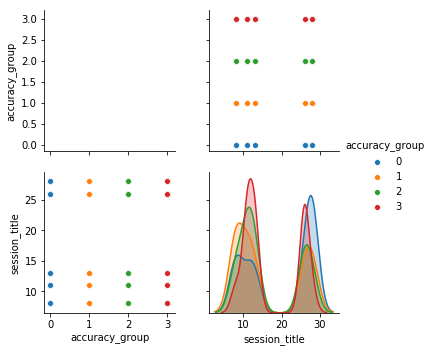

In [24]:
sns.pairplot(new_train[["accuracy_group", "session_title"]], hue='accuracy_group')